In [1]:
# Evaluate the ML model

import tensorflow as tf
from tensorflow import keras
import os
import glob
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import plot_loss, encoder_files_to_tensors, get_best_model_timestamp
from utils import load_model_data_new, unnormalize_params, assess_decoder
from utils import sample_files
from models import EncoderMulti, mse_loss_encoder, mse_loss_decoder

# data_dir = '/eos/user/k/kiliakis/tomo_data/datasets'
data_dir = './tomo_data/datasets'

dataset_percent = 1
normalization = 'minmax'
num_Turns_Case = 50+1

var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']


2022-11-28 09:25:41.711053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 09:25:41.948984: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-28 09:25:41.999309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-11-28 09:25:41.999324: I tensorflow/st

In [3]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TESTING_PATH = os.path.join(ML_dir, 'TESTING')
assert os.path.exists(TESTING_PATH)


# First the training data
file_names = sample_files(TESTING_PATH, dataset_percent, keep_every=num_Turns_Case)

start_t = time.time()
# read input, divide in features/ label, create tensors
x_test, y_test = encoder_files_to_tensors(file_names, normalization=normalization)
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(file_names):.3f}')


2022-11-28 09:26:14.005305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/lib:/usr/lib/x86_64-linux-gnu
2022-11-28 09:26:14.005499: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-28 09:26:14.005526: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2022-11-28 09:26:14.007355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Elapsed time: 99.866, Per file: 0.072


In [46]:
# Model to load
# timestamp = get_best_model_timestamp('./trials', model='enc')
# timestamp = '2022_10_07_15-18-55'
# timestamp = '2022_09_30_17-46-45'
# timestamp = '2022_10_24_12-28-57'
timestamp = 'hybrid'

print(timestamp)

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')
assert os.path.exists(weights_dir)
os.makedirs(plots_dir, exist_ok=True)

models = {}
# load the model
for file in os.listdir(weights_dir):
    if 'backup' in file:
        continue
    var_name = file.split('encoder_')[1].split('.h5')[0]
    models[var_name] = keras.models.load_model(os.path.join(weights_dir, file))


hybrid


In [42]:
test_losses = {}
for var_name, model in models.items():
    idx = var_names.index(var_name)
    print(f'------ Evaluating {var_name} ------')
    test_loss = model.evaluate(x_test, tf.gather(y_test, idx, axis=1))
    test_losses[var_name] = test_loss

# for name, mse in test_losses.items():
#     print(f'{name}:\t{mse:.3e}')

print(f'\nMean loss: {np.mean([v for v in test_losses.values()]):.3e}')


------ Evaluating enEr ------
44/44 [==============================] - 0s 4ms/step - loss: 7.0289e-05
------ Evaluating phEr ------
44/44 [==============================] - 0s 5ms/step - loss: 2.9769e-05
------ Evaluating bl ------
44/44 [==============================] - 0s 3ms/step - loss: 2.4089e-04
------ Evaluating inten ------
44/44 [==============================] - 0s 5ms/step - loss: 0.0824
------ Evaluating mu ------
44/44 [==============================] - 0s 4ms/step - loss: 0.0023 - mae: 0.0340
------ Evaluating Vrf ------
44/44 [==============================] - 0s 6ms/step - loss: 5.8979e-05
------ Evaluating VrfSPS ------
44/44 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0398


/home/kiliakis/install/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: unsupported operand type(s) for +: 'float' and 'list'

In [47]:
test_pred = np.zeros(shape=(len(x_test), len(models)), dtype=float)
for var_name, model in models.items():
    idx = var_names.index(var_name)
    print(f'------ Generating predictions for {var_name} ------')
    test_pred[:, idx] = model.predict(x_test, verbose=False).reshape(-1)

mses = mean_squared_error(y_test, test_pred, multioutput='raw_values')

for name, mse in zip(var_names, mses):
    print(f'{name}:\t{mse:.3e}')

print(f'\nMean loss: {np.mean(mses):.3e}')


------ Generating predictions for enEr ------
------ Generating predictions for phEr ------
------ Generating predictions for bl ------
------ Generating predictions for inten ------
------ Generating predictions for mu ------
------ Generating predictions for Vrf ------
------ Generating predictions for VrfSPS ------
phEr:	2.977e-05
enEr:	7.029e-05
bl:	2.409e-04
inten:	8.242e-02
Vrf:	5.898e-05
mu:	2.286e-03
VrfSPS:	2.308e-03

Mean loss: 1.249e-02


phEr [9.74747475e-01 1.73160173e-02 2.88600289e-03 2.88600289e-03
 7.21500722e-04 7.21500722e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.21500722e-04]
enEr [9.71139971e-01 2.23665224e-02 2.16450216e-03 1.44300144e-03
 7.21500722e-04 0.00000000e+00 7.21500722e-04 0.00000000e+00
 7.21500722e-04 7.21500722e-04]
bl [8.67965368e-01 9.81240981e-02 2.30880231e-02 7.21500722e-03
 7.21500722e-04 7.21500722e-04 1.44300144e-03 0.00000000e+00
 0.00000000e+00 7.21500722e-04]
inten [0.47186147 0.2020202  0.14718615 0.1046176  0.05266955 0.01731602
 0.0007215  0.0021645  0.0007215  0.0007215 ]
Vrf [9.33621934e-01 4.54545455e-02 1.29870130e-02 4.32900433e-03
 0.00000000e+00 0.00000000e+00 1.44300144e-03 7.21500722e-04
 0.00000000e+00 1.44300144e-03]
mu [9.46608947e-01 3.60750361e-02 1.01010101e-02 4.32900433e-03
 2.16450216e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.21500722e-04]
VrfSPS [8.82395382e-01 8.36940837e-02 1.73160173e-02 7.21500722e-03
 6.49350649e-03 2.16450

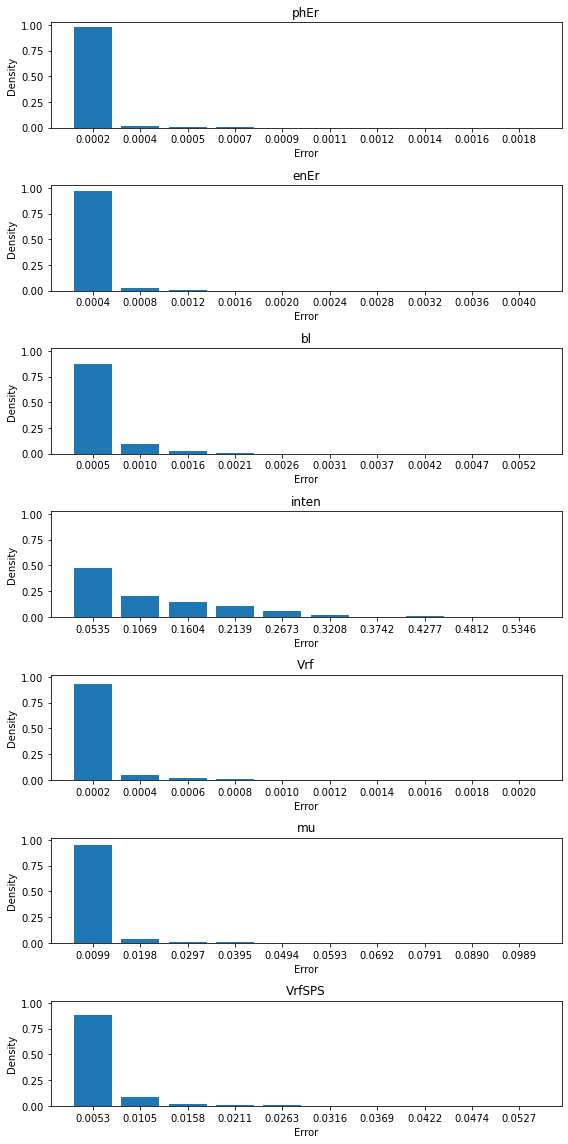

In [48]:
# Also generate MSE histogram
# print(valid_pred.shape)
square_errors = ((y_test - test_pred) * (y_test - test_pred))

fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False, 
sharey=True, figsize=(8, 16))
for i, name in enumerate(var_names):
    hist,edges = np.histogram(square_errors[:, i], bins=10, density=False)
    hist = hist / len(square_errors[:, i])
    print(name, hist)
    ax = axes[i]
    plt.sca(ax)
    plt.bar(np.arange(len(hist)), hist, width=0.8)
    plt.title(name)
    edges = [f'{e:.4f}' for e in edges]
    plt.xticks(np.arange(len(hist)), edges[1:])
    plt.xlabel('Error')
    plt.ylabel('Density')
    plt.tight_layout()


(1386, 7)


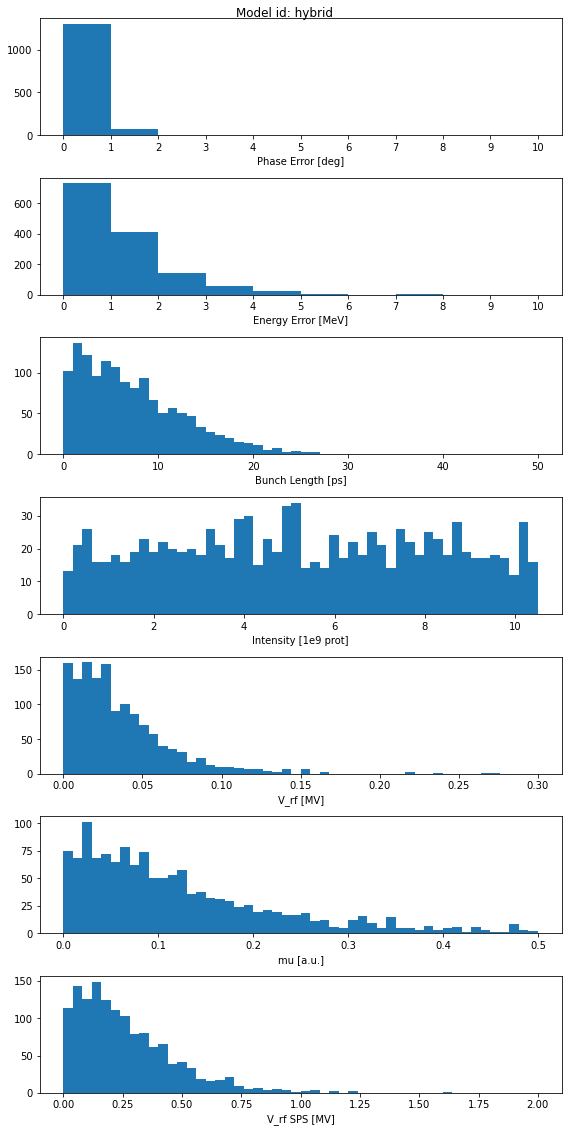

In [49]:

y_test_unnorm = unnormalize_params(
    y_test[:, 0], y_test[:, 1], y_test[:, 2],
    y_test[:, 3], y_test[:, 4], y_test[:, 5],
    y_test[:, 6], normalization=normalization)

y_pred_unnorm = unnormalize_params(
    test_pred[:, 0], test_pred[:, 1], test_pred[:, 2],
    test_pred[:, 3], test_pred[:, 4], test_pred[:, 5],
    test_pred[:, 6], normalization=normalization)

diffs = np.abs(np.array(y_pred_unnorm).T - np.array(y_test_unnorm).T)
print(diffs.shape)
fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False,
                         sharey=False, figsize=(8, 16))
fig.suptitle(f'Model id: {timestamp}')

plt.sca(axes[0])
# plt.hist(diffs[:, 0], bins=100, range=(-50, 50))
plt.hist(diffs[:, 0], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Phase Error [deg]')
plt.sca(axes[1])
plt.hist(diffs[:, 1], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Energy Error [MeV]')
plt.sca(axes[2])
plt.hist(diffs[:, 2]*1e12, bins=50, range=(0, 50))
plt.xlabel('Bunch Length [ps]')
plt.sca(axes[3])
plt.hist(diffs[:, 3]*1e-10, bins=50, range=(0, 10.5))
plt.xlabel('Intensity [1e9 prot]')
plt.sca(axes[4])
plt.hist(diffs[:, 4], bins=50, range=(0, 0.3))
plt.xlabel('V_rf [MV]')
plt.sca(axes[5])
plt.hist(diffs[:, 5], bins=50, range=(0, 0.5))
plt.xlabel('mu [a.u.]')
plt.sca(axes[6])
plt.hist(diffs[:, 6], bins=50, range=(0, 2))
plt.xlabel('V_rf SPS [MV]')
plt.tight_layout()
# plt.savefig('plots/enc-evaluation-hybrid.jpg', dpi=400)



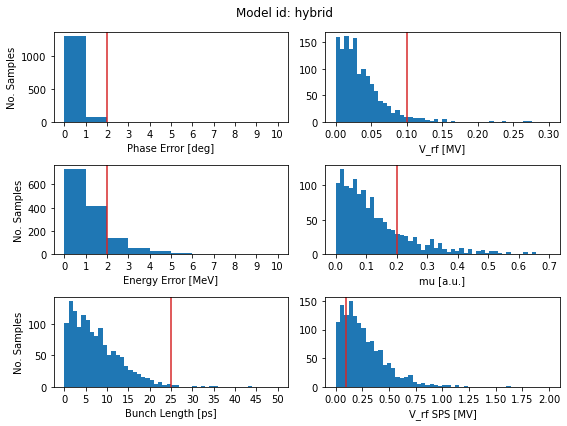

In [50]:
fig, axes = plt.subplots(ncols=2, nrows=3, sharex=False,
                         sharey=False, figsize=(8, 6))
fig.suptitle(f'Model id: {timestamp}')

plt.sca(axes[0][0])
plt.hist(diffs[:, 0], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Phase Error [deg]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='tab:red')

plt.sca(axes[1][0])
plt.hist(diffs[:, 1], bins=10, range=(0, 10))
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Energy Error [MeV]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='tab:red')

plt.sca(axes[2][0])
plt.hist(diffs[:, 2]*1e12, bins=50, range=(0, 50))
plt.xticks(np.arange(0, 50.5, 5))
plt.xlabel('Bunch Length [ps]')
plt.ylabel('No. Samples')
plt.axvline(x=25, color='tab:red')

plt.sca(axes[0][1])
plt.hist(diffs[:, 4], bins=50, range=(0, 0.3))
plt.xlabel('V_rf [MV]')
plt.axvline(x=0.1, color='tab:red')

plt.sca(axes[1][1])
plt.hist(diffs[:, 5], bins=50, range=(0, 0.7))
plt.xticks(np.arange(0, 0.71, 0.1))
plt.xlabel('mu [a.u.]')
plt.axvline(x=0.2, color='tab:red')

plt.sca(axes[2][1])
plt.hist(diffs[:, 6], bins=50, range=(0, 2))
plt.xticks(np.arange(0, 2.1, 0.25))
plt.xlabel('V_rf SPS [MV]')
plt.axvline(x=0.1, color='tab:red')

plt.tight_layout()
# plt.savefig('plots/enc-evaluation-hybrid-sec-meeting.jpg', dpi=400)
